First you need to install transformers and nlp package from Huggingface.

In [ ]:
!pip install transformers
!pip install nlp

Now let's check which gpu colab will give to us and let's hope that is a P100 or T4.

In [ ]:
!nvidia-smi

Tue Jun 30 07:31:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import transformers
import nlp
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import gc
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup
import re
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import time
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import time
import torch.nn as nn
import seaborn as sns 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    - Remove url (eg. 'https://...', 'http://...', 'www...' to '')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """


    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    #remove url with http
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

    #remove url with www
    text = re.sub(r'www\..*[\r\n]*', '', text, flags=re.MULTILINE)

    return text


def initialize_model(epochs = 3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    @param epoch: (int) number of epoch to train the model

    @return bert_classifier: (BertForSequenceClassification) bert model used for training
    @return optimizer:  optimizer used for training
    @return scheduler: (torch.optim) scheduler used for training
    """
    # Instantiate Bert Classifier
    bert_classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler with warmup
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps= 0 , # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    @param seed: (int) seed used in different random number generator.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, scheduler, train_dataloader, val_dataloader=None, epochs = 3, evaluation=False):
    """Train the BertClassifier model.
    @param model: (BertForSequenceClassification)
    @param optimizer: optimizer used for training
    @param scheduler: (torch.optim) scheduler used for training
    @param train_dataloader: (torch.utils.data.dataloader.DataLoader)
    @param val_dataloader: (torch.utils.data.dataloader.DataLoader)
    @param epoch: (int) number of epoch
    @param evaluation: (Bool) parameter to choose if evaluate or not at the end of epoch.
    """
    # Start training loop
    print("Start training...\n")
    
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)[0]
            
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 1000 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.

    @param model: (BertForSequenceClassification) model to evaluate
    @param val_dataloader: (torch.utils.data.dataloader.DataLoader) dataloader of validation set

    @return val_los: (np.float) Validation loss calculated on the model applied on validation set.
    @return val_accuracy: (np.float) Validation Accuracy calculated on the model applied on validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)[0]

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def preprocessing_for_bert(data, tokenizer):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @param    tokenizer(transformers.tokenization_bert): Tokenizer used to tokenize the sentence

    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in tqdm(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs

        #encoding sentence
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            truncation = True,              # Truncate sentence to MAX_LEN
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


With NLP you can download different dataset easily.
We will use sentiment140 a dataset of over 1.600.000 different tweets for sentiment analysis.

In [ ]:
#We will use only train dataset because it is very large.
sentiment140 = nlp.load_dataset('sentiment140', split = 'train')

We will use half of the dataset in particular 800.000 for train and 200.000 for test.

In [ ]:
#Import sentiment column to define the split
strat_supp = pd.DataFrame(sentiment140['sentiment']).values
print(f'Total number of observation: {strat_supp.shape[0]}\n')

#With two different split we will take the needed amount of data
_, supp, _strat, strat = train_test_split(pd.DataFrame(sentiment140).loc[:, ['text', 'sentiment']], strat_supp, test_size = .625, random_state = 3, shuffle = True, stratify = strat_supp)
train_df, test_df = train_test_split(supp, test_size = .2, random_state = 3, shuffle = True, stratify = strat)

print(f'Train data used: {train_df.shape[0]}; Test data used: {test_df.shape[0]}')

#free some memory
del _, supp, _strat, strat, strat_supp
gc.collect()

Total number of observation: 1600000

Train data used: 800000; Test data used: 200000


22

Let's check the distribution of the length of the sentence of all the tweets.

In [ ]:
#import Bert Tokenizer with huggingface
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

137.0


10

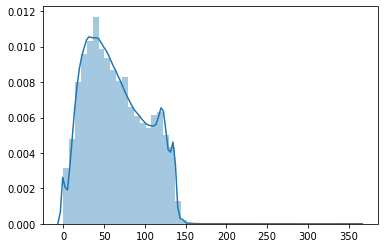

In [ ]:
supp = pd.DataFrame(nlp.load_dataset('sentiment140', split = 'train'))['text']

#Pre-process and clean the text and apply tokenization
supp = [text_preprocessing(x) for x in supp]
supp_length = [len(x) for x in supp]

#distribution of tweet length
sns.distplot(supp_length)
print(np.quantile([len(x) for x in supp], .99))

del supp, supp_length
gc.collect()

We can see that setting max length as 150 is a good choice. In this way every tweet is truncated to 150 

In [ ]:
MAX_LEN = 150

Set the device as cuda if it's available otherwise cpu.

In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Pre process the tweet to clean error and html part.

In [ ]:
text_train, label_train = [text_preprocessing(sent) for sent in tqdm(train_df.text)], train_df.sentiment.tolist()
text_test, label_test = [text_preprocessing(sent) for sent in tqdm(test_df.text)], test_df.sentiment.tolist()

# del train, test
gc.collect()

5921

Clean of dataset by removing empty tweet.

In [ ]:
#remove blank tweet
remove_train = [len(x) > 0 for x in text_train]
text_train, label_train = list(np.array(text_train)[remove_train]), list(np.array(label_train)[remove_train])

remove_test = [len(x) > 0 for x in text_test]
text_test, label_test = list(np.array(text_test)[remove_test]), list(np.array(label_test)[remove_test])

Set the label in correct format by switching the value 4 --> 1 for positive tweet.

In [ ]:
label_train = [1 if x > 0  else 0 for x in label_train]
label_test = [1 if x > 0  else 0 for x in label_test]


Tokenization pipeline to get input and attention mask for train and test.

In [ ]:
train_inputs, train_masks = preprocessing_for_bert(text_train, tokenizer)
val_inputs, val_masks = preprocessing_for_bert(text_test, tokenizer)

Create tensor and dataloader for train and validation. We will use batch size as 32 as recommended by BERT's author.

In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(label_train)
val_labels = torch.tensor(label_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

gc.collect()

406

In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

Load the classifier, optimizer and scheduler.

In [ ]:
set_seed()
bert_classifier, optimizer, scheduler = initialize_model(epochs = 2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Let's train the classifier for 2 epoch over the 800.000 different tweet.

In [ ]:
train(bert_classifier, optimizer, scheduler, train_dataloader, val_dataloader, epochs = 2, evaluation = True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |  1000   |   0.432341   |     -      |     -     |  466.51  
   1    |  2000   |   0.381585   |     -      |     -     |  465.80  
   1    |  3000   |   0.383168   |     -      |     -     |  465.86  
   1    |  4000   |   0.372440   |     -      |     -     |  466.06  
   1    |  5000   |   0.370665   |     -      |     -     |  466.12  
   1    |  6000   |   0.370374   |     -      |     -     |  466.76  
   1    |  7000   |   0.362668   |     -      |     -     |  466.88  
   1    |  8000   |   0.355139   |     -      |     -     |  467.01  
   1    |  9000   |   0.349685   |     -      |     -     |  466.93  
   1    |  10000  |   0.350752   |     -      |     -     |  467.03  
   1    |  11000  |   0.351598   |     -      |     -     |  467.06  
   1    |  12000  |   0.341833   |     -      |     -     |  467.20  


Now i will mount my google drive to save the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Save the model as suggested by huggingface.

In [ ]:
from transformers.file_utils import cached_path, WEIGHTS_NAME
WEIGHTS_NAME
torch.save(bert_classifier.state_dict(), f'/content/gdrive/My Drive/Progetti Lavoro/{WEIGHTS_NAME}')